<h2>Imports and loading the dataset</h2><br>
This code cell handles all library and dataset importing.

In [1]:
 # standard libraries
import math, os, time, glob, random
import numpy as np

from os.path import exists

# plotting
import matplotlib.pyplot as plt

# progress bars
from tqdm.notebook import trange, tqdm

# PyTorch
import torch
import torch.nn as nn # lets not write out torch.nn every time
import torch.nn.functional as F # functional versions of the modules in torch.nn
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the stored numpy arrays
X = np.load("./sign-language-digits-dataset/X.npy")
Y = np.load("./sign-language-digits-dataset/Y.npy")

# lets inspect their shape
print(f"Shape of X: {X.shape}, shape of Y: {Y.shape}")

# Looks like we have 2062 samples, the images are 64x64 grayscale
# the labels look like they are stored as a probability distribution (a.k.a. one-hot encoding) over the 10 classes:
print(f"Y[0]={Y[0]}, Y[600]={Y[1000]}")

Shape of X: (2062, 64, 64), shape of Y: (2062, 10)
Y[0]=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Y[600]=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


We then convert the one-hot encoding (i.e. elements of {0,1}^10) to elements of {0,...,9}. This is done using the fact that only one vector element is nonzero, which implies that the argmax returns the index of the 1 (note that computer sequences start at zero so argmax maps into {0,...,9}).

In [2]:
Y = np.argmax(Y, -1)

print(f"Y[0]={Y[0]}, Y[600]={Y[1000]}")

Y[0]=0, Y[600]=4


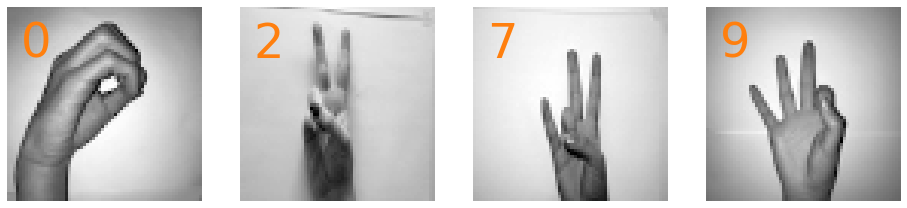

In [3]:
# Lets visualize some of the samples
show = (100, 600, 1500, 2000)
plt.figure(figsize=[4*len(show), 4])

for i in range(len(show)):
    plt.subplot(1, len(show), i+1)
    plt.imshow(X[show[i]], cmap='gray_r')
    plt.text(4, 4, f"{Y[show[i]]}", va='top' ,color='C1', fontsize=48)
    plt.axis("off")
    
plt.show()

We will now split the dataset into training and testing data, and set a random seed to make reproducible results. To split the dataset, we choose a random starting point such that X[start:end] has the right amount of elements. The testing dataset will then be defined as 'test dataset = dataset \ training dataset' (but in a way which NumPy understands), where \ denotes set theoretic difference. The random split is implemented in order to avoid overfitting on one particular split.

In [4]:
# 'Universal constants'
RANDOM_SEED = 694201337
NUMBER_OF_CLASSES = 10 # this avoids 'magic numbers' later in the code
DATASET_SIZE = X.shape[0]

# Hyper parameters
PERCENTAGE_TEST = 30
LEARNING_RATE = 0.007
BATCH_SIZE = 4
N_EPOCHS_1 = 40
N_EPOCHS_2 = 27


random.seed(RANDOM_SEED)

# Custom dataset split function before I realized that torch.utils.data.random_split exists
def split_train_test(X,Y):
    training_elements = round(DATASET_SIZE * (1-PERCENTAGE_TEST/100))
    start_point = random.randint(0, DATASET_SIZE - training_elements)

    X_train = X[start_point:start_point+training_elements]
    Y_train = Y[start_point:start_point+training_elements]

    X_test = np.concatenate((X[0:start_point], X[start_point+training_elements:]), axis=0)
    Y_test = np.concatenate((Y[0:start_point], Y[start_point+training_elements:]), axis=0)

    #terminate the program if train size + test size unequal tot DATASET_SIZE
    assert(not DATASET_SIZE - X_train.shape[0] - X_test.shape[0])
    
    return (X_train,Y_train,X_test,Y_test)

# Make the data readable to PyTorch
X = torch.tensor(X).unsqueeze(1).to(device)
Y = torch.tensor(Y).to(device)
dataset = torch.utils.data.TensorDataset(X,Y)

In [5]:
# Sanity check on list slicing/concatenation
A = [0,1,2,3,4,5,6,7,8,9,10,11]

#List slicing is non inclusive at the end
A[0:3]+A[6:9], [A[3],A[9]], np.concatenate((np.array(A[0:3]),np.array(A[6:9])),axis=0)

([0, 1, 2, 6, 7, 8], [3, 9], array([0, 1, 2, 6, 7, 8]))

<h2>The network architecture, and training the network</h2>

The network we will use is based on the LeNet-5 architecture (see, for example, https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320; in fact a lot of code in this project is based on this article, this article will be refered to as [LeNet-5]). However we will make some modifications, in particular we will use ReLU activation functions rather than tanh. Furthermore the pictures in our dataset are twice the size of the ones in the MNIST dataset (for which LeNet-5 was created), to deal with this the dimensions of some layers have been modified. <br>
The other architecture is based on the following github page which solves a similar problem: https://github.com/francislata/Sign-Language-Digits-CNN/blob/master/model.py. <br>
To keep track of the dimensions of each layer, we use the following formula for pooling and convolution layers (see the PyTorch documentation):
![image](https://i.imgur.com/49clMN9.png)

In [6]:
class LeNet5_clone(nn.Module): # Class inherits from nn.Module
    
    def __init__(self, number_of_classes):
        super(LeNet5_clone, self).__init__()
        
        # We separate the network into a feature extractor and classifier 
        
        # This sequence contains the convolution layers, and works with picture data
        self.feature_extractor = nn.Sequential(
            # in: 1×64×64
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(), #6×60×60
            nn.AvgPool2d(kernel_size=2), #6×30×30
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(), #16×26×26
            nn.AvgPool2d(kernel_size=2), #16×13×13
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, stride=1),
            nn.ReLU() #64×9×9
        )
        
        # This sequence contains the fully connected layers and works on flattened data
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*9*9, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=number_of_classes),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        
        # We transform the logits to probits (i.e. a probability mass function)
        probs = F.softmax(logits, dim=1)
        
        return logits,probs

class NN_2(nn.Module):
    def __init__(self):
        super(NN_2, self).__init__()

        self.feature_extractor = nn.Sequential(
            # in: 1×64×64
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(), # 32×64×64
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 32×32×32
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(), # 64×32×32
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 64×16×16
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(), # 128×16×16
            nn.MaxPool2d(kernel_size = 2,stride = 2), # 128×8×8
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        
        return logits,probs
    
    

In [7]:
torch.manual_seed(RANDOM_SEED)

# We use our model based on LeNet-5 in combinations with the
# SGD optimizer using a cross-entropy loss function
model_1 = LeNet5_clone(NUMBER_OF_CLASSES).to(device)
model_2 = NN_2().to(device)

optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=LEARNING_RATE)
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
    
print(model_1)
print(model_2)

print(f"The LeNet-5 clone has {sum(p.numel() for p in model_1.parameters())} parameters")
print(f"The second network has {sum(p.numel() for p in model_2.parameters())} parameters")

LeNet5_clone(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=5184, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
    (3): ReLU()
  )
)
NN_2(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=

It can be seen that the second network has more parameters by a factor of almost 10.

The following function defines the training sequence and is based on the same article that creates a clone of the LeNet-5 network.

In [8]:
def timestamp():
    '''
    returns the current time in 'year_month_day_hour_minutes_seconds'
    '''
    t = time.localtime()
    return time.strftime('%Y_%b_%d_%H_%M_%S', t)

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    Copied from [LeNet-5], comments added for clarity
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval() # Put the model in evaluation mode
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)
            
            # We get the softmax of the model predictions and then convert it to
            # the expected answer, note that this is done in a vectorized manner
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)
            
            
            # We add the size of the batch to n and add the
            # number of correct predictions to correct_pref
            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    Copied from [LeNet-5], comments added for clarity
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')
    
    # The losses are converted to NumPy format
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    # Standard MatPlotLib plotting procedure
    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

def plot_accuracy(train_losses, valid_losses):
    '''
    Copy-paste of plot_losses
    This violates the "don't repeat yourself" coding convention 
    (but I can't be asked to pass a third parameter into the plot function)
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')
    
    # The losses are converted to NumPy format
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    # Standard MatPlotLib plotting procedure
    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training accuracy') 
    ax.plot(valid_losses, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')


def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    Copied from [LeNet-5], comments added for clarity
    
    All the PyTorch specific stuff (models, optimizers, etc.) is passed
    (hopefully as a pointer but that depends on how Python handles this)
    to the function in order to make it easy to try out other models etc.
    '''

    model.train()
    
    # A running loss is used to keep track of losses across batches
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad() # Reset optimizer gradients
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass, i.e. make the model predict stuff
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass, i.e. update the weights using backpropagation
        loss.backward()
        optimizer.step()
    
    # epoch_loss is the mean of the individual batch losses
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss



def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    Copied from [LeNet-5], comments added for clarity
    '''

    model.eval()
    
    # A running loss is used to keep track of losses across batches
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and update running loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)
        
        # As we are validating, there is no backwards pass

    # We again take the mean over all batches
    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    Copied from [LeNet-5], comments added for clarity
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    
    train_losses = []
    valid_losses = []
    
    train_accu = []
    valid_accu = []
 
    # Train model
    for epoch in range(0, epochs):

        # Train the model, then add the losses to the loss array
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validate the model on the validation dataset
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
        
        
        # TODO: this is very inefficient
        train_acc = get_accuracy(model, train_loader, device=device)
        valid_acc = get_accuracy(model, valid_loader, device=device)
        
        train_accu.append(train_acc)
        valid_accu.append(valid_acc)

        # Print the loss and accuracy when print_every|epoch
        if epoch % print_every == (print_every - 1):
                
            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    plot_accuracy(train_accu, valid_accu)
    
    return model, optimizer, (train_losses, valid_losses), (train_accu, valid_accu)

The following cell trains the models.

In [9]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
test_losses = []

# Calculate the size of the validation dataset using hyperparameters
test_size = round(DATASET_SIZE * PERCENTAGE_TEST/100)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, 
            [DATASET_SIZE - test_size, test_size])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

path_1 = f"Lenet-5-clone_LR={LEARNING_RATE}_BS={BATCH_SIZE}_EPOCH={N_EPOCHS_1}.pth"
path_2 = f"Network-2_LR={LEARNING_RATE}_BS={BATCH_SIZE}_EPOCH={N_EPOCHS_2}.pth"

if not os.path.exists(path_1):
    model_1, optimizer_1, _, _ = training_loop(model_1, criterion, optimizer_1,
                                        train_loader, valid_loader, N_EPOCHS_1, device)

    # Save the model at the end of training
    torch.save({
        'epoch': N_EPOCHS_1,
        'model_state_dict': model_1.state_dict(),
        'optimizer_state_dict': optimizer_1.state_dict(),
    }, path_1)
else:
    network_1 = torch.load(path_1)
    
    model_1.load_state_dict(network_1['model_state_dict'])
    optimizer_1.load_state_dict(network_1['optimizer_state_dict'])


if not os.path.exists(path_2):
    model_2, optimizer_2, _, _ = training_loop(model_2, criterion, optimizer_2,
                                        train_loader, valid_loader, N_EPOCHS_2, device)

    torch.save({
        'epoch': N_EPOCHS_2,
        'model_state_dict': model_2.state_dict(),
        'optimizer_state_dict': optimizer_2.state_dict(),
    }, path_2)
else:
    network_2 = torch.load(path_2)
    
    model_2.load_state_dict(network_2['model_state_dict'])
    optimizer_2.load_state_dict(network_2['optimizer_state_dict'])

RuntimeError: Error(s) in loading state_dict for NN_2:
	Missing key(s) in state_dict: "classifier.4.weight", "classifier.4.bias". 
	size mismatch for feature_extractor.0.weight: copying a param with shape torch.Size([6, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for feature_extractor.0.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for feature_extractor.3.weight: copying a param with shape torch.Size([16, 6, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for feature_extractor.3.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for feature_extractor.6.weight: copying a param with shape torch.Size([64, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for feature_extractor.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([84, 5184]) from checkpoint, the shape in current model is torch.Size([512, 8192]).
	size mismatch for classifier.0.bias: copying a param with shape torch.Size([84]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for classifier.2.weight: copying a param with shape torch.Size([10, 84]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for classifier.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([128]).

In [ ]:
# Print some of the photos including the model's prediction (copied from [LeNet-5])
ROW_IMG = 5
N_ROWS = 5

# Reasonably standard MatPlotLib stuff
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset[index][0].squeeze(0), cmap='gray_r')
    
    with torch.no_grad():
        model_1.eval()
        # This one includes the prediction of the LeNet-5 clone
        _, probs = model_1(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 clone network - predictions');

In [ ]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset[index][0].squeeze(0), cmap='gray_r')
    
    with torch.no_grad():
        model_2.eval()
        # This one include the prediction of the second network
        _, probs = model_2(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('Second network - predictions');

This cell will contain the relevant graphs (so the grader doesn't have to spend significant time retraining the networks)<br>
These images contain the cross-entropy loss and accuracy of the LeNet-5 clone network as a function of the epoch
![image](https://i.imgur.com/Cnqf52n.png)
![image](https://i.imgur.com/UfYtpuy.png) <br>
The following images contain the cross-entropy loss and accuracy of the second network as a function of the epoch
![image](https://i.imgur.com/bBspZ8Y.png)
![image](https://i.imgur.com/L0czAa1.png)
It can be seen (by looking very closely, or by checking the logs while training the network) that the LeNet-5 clone peaks at around 90% accuracy on validation data, and the second network peaks at around 92% accuracy.

<h2>Experiment</h2>
We will now validate both networks on rotated data. First we need to rotate the images, we will do so by 90 degrees counterclockwise. This is done using the torch.rot90 function.

In [ ]:
# X.shape = (..., 1, 64, 64) so we want to rotate the (2,3)-axis
X = torch.rot90(X, 1, [2,3])

show = (100, 600, 1500, 2000)
plt.figure(figsize=[4*len(show), 4])

for i in range(len(show)):
    plt.subplot(1, len(show), i+1)
    plt.imshow(X.squeeze(1)[show[i]], cmap='gray_r')
    plt.text(4, 4, f"{Y[show[i]]}", va='top' ,color='C1', fontsize=48)
    plt.axis("off")
    
plt.show()

In [ ]:
# We will now show the predictions on a rotated version of the dataset
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(torch.rot90(valid_dataset[index][0].squeeze(0),1,[0,1]), cmap='gray_r')
    
    with torch.no_grad():
        model_1.eval()
        # This one includes the prediction of the LeNet-5 clone
        _, probs = model_1(torch.rot90(valid_dataset[index][0].unsqueeze(0),1,[2,3]))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 clone network - predictions, rotated');

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(torch.rot90(valid_dataset[index][0].squeeze(0),1,[0,1]), cmap='gray_r')
    
    with torch.no_grad():
        model_2.eval()
        # This one include the prediction of the second network
        _, probs = model_2(torch.rot90(valid_dataset[index][0].unsqueeze(0),1,[2,3]))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('Second network - predictions, rotated');

It can be seen that the network does not work at all on rotated data. This is as expected, as no parameters are dedicated to learning about rotations (as there isn't any rotated data to begin with). A way to solve this is by implementing an SE(2)-equivariant CNN on our data. This can be done using, for example, the e2cnn library (https://github.com/QUVA-Lab/e2cnn).